In [217]:
import os, sys, io, time
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import interp1d, InterpolatedUnivariateSpline

from numpy import sqrt, exp, pi, square
from tqdm import tqdm
from multiprocessing import Pool

def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = False):
    if isinstance(sci, str):
        plt.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))

    if title != None: plt.title(title)
    if xbounds != None: plt.xlim(xbounds)
    if ybounds != None: plt.ylim(ybounds)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None:  plt.ylabel(ylabel)
    if isinstance(colorbar,str):
        plt.colorbar(label = colorbar)
    elif colorbar:
        plt.colorbar(label = '$Number\ of\ Entries$')
    else:
        pass

In [218]:
# Read All files
files = ['170202_1747.pkl']

folder = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/PreTriggerPeaks'
df_peak = pd.concat([pd.read_pickle(os.path.join(folder, file)) for file in files])
folder = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/Elist'
df_elist = pd.concat([pd.read_pickle(os.path.join(folder, file)) for file in files])
folder = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/LargeS2'
df_event = pd.concat([pd.read_pickle(os.path.join(folder, file)) for file in files])

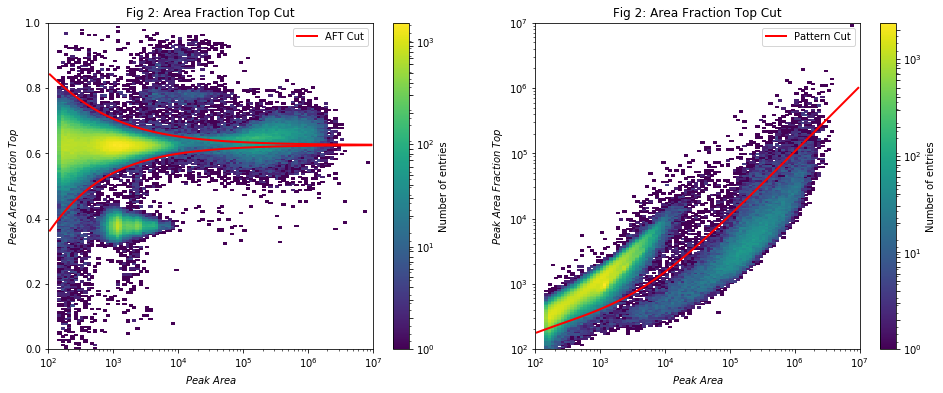

In [219]:
from scipy.stats import beta
plt.rcParams['figure.figsize'] = (16, 6)
fig = plt.figure()

aft = 0.6256
@np.vectorize
def upper_lim(s2):
    return beta.ppf(1-1e-6, a = s2*0.75*aft+1, b = s2*0.75*(1-aft)+1)
@np.vectorize
def lower_lim(s2):
    return beta.ppf(1e-6, a = s2*0.75*aft+1, b = s2*0.75*(1-aft)+1)

s2 = np.logspace(0, 10, 10000)
ul = upper_lim(s2); ll = lower_lim(s2)
upper_lim = interp1d(s2, ul, fill_value = 'extrapolate')
lower_lim = interp1d(s2, ll, fill_value = 'extrapolate')

######################################################
ax = fig.add_subplot(121)
args = ['{df}.area', '{df}.area_fraction_top']
dfs = ['df_event']
mha = Histdd(eval(args[0].format(df = dfs[0])), eval(args[1].format(df = dfs[0])),
             bins = [np.logspace(2, 7, 101), np.linspace(0, 1, 201)]
            )
mha.plot(log_scale = True, alpha = 1.0, cmap=plt.get_cmap('viridis'))
x = mha.bin_centers(axis = 0)

plt.plot(x, upper_lim(x), 'r-', x, lw = 2.0)
plt.legend(['AFT Cut'])
plt.plot(x, lower_lim(x), 'r-', x, lw = 2.0)
plt.xscale('log')
plt_config(xlabel = '$Peak\ Area$', ylabel = '$Peak\ Area\ Fraction\ Top$', title = 'Fig 2: Area Fraction Top Cut')

######################################################
ax = fig.add_subplot(122)
args = ['{df}.area', '{df}.goodness_of_fit_nn']
dfs = ['df_event']
mha = Histdd(eval(args[0].format(df = dfs[0])), eval(args[1].format(df = dfs[0])),
             bins = [np.logspace(2, 7, 101), np.logspace(2, 7, 201)]
            )
mha.plot(log_scale = True, alpha = 1.0, cmap=plt.get_cmap('viridis'))
x = mha.bin_centers(axis = 0)
plt.plot(x, 0.1064*x+758.80*x**0.05639-819.29,'r-', lw = 2.0)
plt.legend(['Pattern Cut'])

plt.xscale('log')
plt.yscale('log')
plt_config(xlabel = '$Peak\ Area$', ylabel = '$Peak\ Area\ Fraction\ Top$', title = 'Fig 2: Area Fraction Top Cut')

plt.show()

In [94]:
lone_s1_list = set(range(21602)).difference(df_event.event_number.unique())

In [220]:
from pax.utils import Memoize
# Aiming to have 1) Privious S2 Area and time
start = time.time()

@Memoize
def get_previous_event_s2_area(event_number):
    event_number = event_number - 1
    temp = df_event.loc[df_event.event_number == event_number].area.values
    if len(temp) > 0:
        return temp
    else:
        return [0]

@Memoize
def get_previous_event_s2_time(event_number):
    event_number = event_number - 1
    temp = df_event.loc[df_event.event_number == event_number].hit_time_mean_global.values
    if len(temp) > 0:
        return temp
    else:
        return [0]

df_peak['previous_event_s2_areas'] = [get_previous_event_s2_area(n) for n in df_peak.event_number.values]
df_peak['previous_event_s2_times'] = [get_previous_event_s2_time(n) for n in df_peak.event_number.values]
df_peak['previous_event_largest_s2_area'] = [np.amax(areas) for areas in df_peak.previous_event_s2_areas.values]
df_peak['previous_event_largest_s2_index'] = [np.argmax(areas) for areas in df_peak.previous_event_s2_areas.values]
df_peak['previous_event_largest_s2_time'] = [df_peak.previous_event_s2_times.values[ix][iy] for ix, iy in enumerate(df_peak['previous_event_largest_s2_index'])]

end = time.time()
print(end - start)

2.8627123832702637


In [194]:
beta = 125e6
df_peak['previous_event_s2_area_adjusted'] = [np.sum(df_peak.previous_event_s2_areas.values[ix]\
                                              *np.exp(-(Ltime - df_peak.previous_event_s2_times.values[ix])/beta)) \
                                              for ix, Ltime in enumerate(df_peak.previous_event_largest_s2_time.values)]

df_peak['previous_event_largest_s2_delay'] = df_peak.hit_time_mean_global - df_peak.previous_event_largest_s2_time

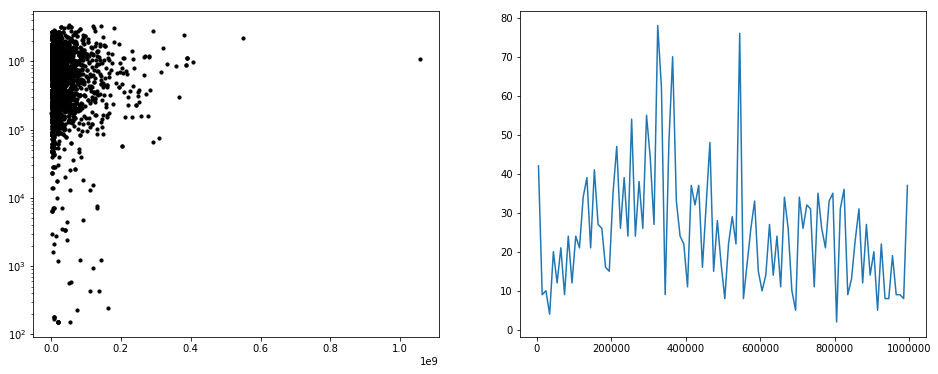

In [216]:
plt.rcParams['figure.figsize'] = (16, 6)
fig = plt.figure()

ax = fig.add_subplot(121)
argx, argy = '{df}.previous_event_largest_s2_delay', '{df}.previous_event_s2_area_adjusted'
dfs = ['df_peak[df_peak.previous_event_s2_area_adjusted > 10]']
plt.scatter(eval(argx.format(df = dfs[0])), eval(argy.format(df = dfs[0])), s = 10, color = 'k')
plt.yscale('log')

ax = fig.add_subplot(122)
ph = Hist1d(eval(argy.format(df = dfs[0])), bins = np.linspace(0, 1e6, 101))
plt.plot(ph.bin_centers, ph.histogram)


plt.show()